In [57]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [58]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [59]:
# here i will use monthly data
df= df.resample(rule='MS').apply(first_day)

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='snapped_at'>

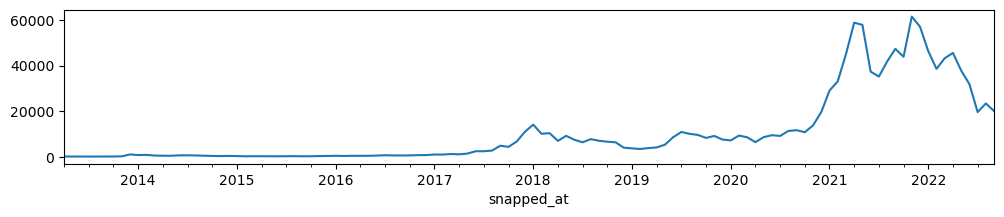

In [61]:
results = seasonal_decompose(df['price'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

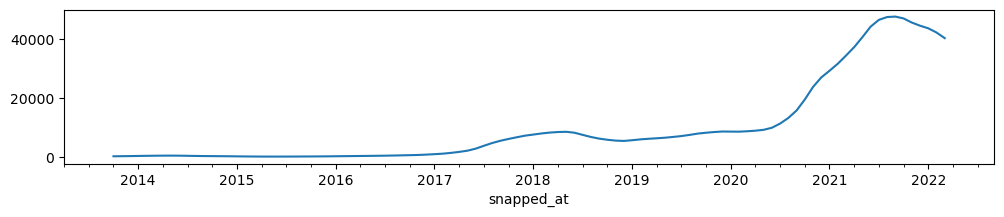

In [62]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

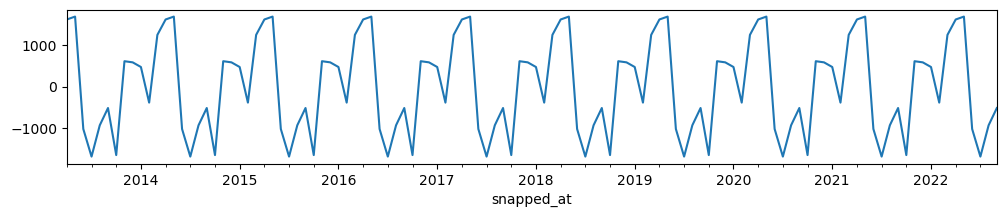

In [63]:
results.seasonal.plot(figsize=(12,2))

In [64]:
len(df)

114

In [65]:
train = df

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [68]:
# we do this just on the training data as in real life we have no idea of the actual datra to fit for the test set
scaler.fit(train) # finds the max value in the training set

MinMaxScaler()

In [69]:
# transform the training and test data via the scaler object above. MinMaxscaler doesnt simply divide 
# by athe max or min value... it uses more complex method
scaled_train = scaler.transform(train)

In [70]:
# now everything is scaled we need to createa timeseries generator to feed the neural network
from keras.preprocessing.sequence import TimeseriesGenerator

In [71]:
# Redefine to get 12 months back and then predict the next month out
n_input = 12
n_features = 1 # for time series it is 1 as we have one output the prediction (one column of data)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [72]:
# Create the model , train it and test it
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [73]:
# define model
model = Sequential()
# 100 is the number of neurons. we play around to find a good number and you play around
model.add(LSTM(1000, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1000)              4008000   
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________


In [75]:
# 1 epoch is a single run through all our data
model.fit(generator,epochs=200)

Epoch 1/200
102/102 [==============================] - 9s 80ms/step - loss: 0.0322
Epoch 2/200
102/102 [==============================] - 9s 92ms/step - loss: 0.0232
Epoch 3/200
102/102 [==============================] - 9s 84ms/step - loss: 0.0289
Epoch 4/200
102/102 [==============================] - 8s 82ms/step - loss: 0.0154
Epoch 5/200
102/102 [==============================] - 9s 84ms/step - loss: 0.0166
Epoch 6/200
102/102 [==============================] - 8s 81ms/step - loss: 0.0141
Epoch 7/200
102/102 [==============================] - 9s 84ms/step - loss: 0.0108
Epoch 8/200
102/102 [==============================] - 8s 81ms/step - loss: 0.0106
Epoch 9/200
102/102 [==============================] - 9s 86ms/step - loss: 0.0098
Epoch 10/200
102/102 [==============================] - 8s 80ms/step - loss: 0.0101
Epoch 11/200
102/102 [==============================] - 9s 86ms/step - loss: 0.0083
Epoch 12/200
102/102 [==============================] - 8s 81ms/step - loss: 0.0076
E

102/102 [==============================] - 8s 80ms/step - loss: 0.0013
Epoch 99/200
102/102 [==============================] - 8s 81ms/step - loss: 0.0013
Epoch 100/200
102/102 [==============================] - 8s 79ms/step - loss: 0.0014
Epoch 101/200
102/102 [==============================] - 8s 82ms/step - loss: 0.0014
Epoch 102/200
102/102 [==============================] - 8s 78ms/step - loss: 0.0020
Epoch 103/200
102/102 [==============================] - 8s 82ms/step - loss: 0.0011
Epoch 104/200
102/102 [==============================] - 8s 78ms/step - loss: 0.0012
Epoch 105/200
102/102 [==============================] - 9s 83ms/step - loss: 0.0014
Epoch 106/200
102/102 [==============================] - 8s 78ms/step - loss: 0.0014
Epoch 107/200
102/102 [==============================] - 8s 83ms/step - loss: 0.0013
Epoch 108/200
102/102 [==============================] - 8s 77ms/step - loss: 0.0015
Epoch 109/200
102/102 [==============================] - 8s 83ms/step - loss: 0.

102/102 [==============================] - 8s 76ms/step - loss: 4.0080e-04
Epoch 193/200
102/102 [==============================] - 12s 121ms/step - loss: 3.1282e-04
Epoch 194/200
102/102 [==============================] - 11s 106ms/step - loss: 3.4585e-04
Epoch 195/200
102/102 [==============================] - 10s 96ms/step - loss: 3.8828e-04
Epoch 196/200
102/102 [==============================] - 10s 99ms/step - loss: 9.1394e-04
Epoch 197/200
102/102 [==============================] - 11s 112ms/step - loss: 6.7257e-04
Epoch 198/200
102/102 [==============================] - 11s 107ms/step - loss: 6.4983e-04
Epoch 199/200
102/102 [==============================] - 9s 91ms/step - loss: 5.3475e-04
Epoch 200/200
102/102 [==============================] - 9s 92ms/step - loss: 3.8262e-04


In [87]:
model.history.history.keys()

dict_keys([])

In [88]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

KeyError: 'loss'

In [89]:
# our model takes the last 12 history steps and predicts the next one 
first_eval_batch = scaled_train[-12:]

In [90]:
# in order to actually forecast into the future
test_predictions = [] # holding the predictions as we go along

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# we use the predicted points to predict further and further into the future 
# so RNN cannot work very well far into the future
# in order to predict into the future we can change the range for example len(test)+6 to forecast another 6 months
# or we can use the actual df2 to train and freely forecast into the future!
for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [91]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [92]:
true_predictions

array([[15758.61017008],
       [14695.40820005],
       [14401.01752466],
       [14417.35411877],
       [14616.22560728],
       [14625.36104021],
       [14805.04711354],
       [15471.16915481],
       [16977.97326185],
       [22100.44070225],
       [29471.77755012],
       [36331.91060596],
       [47090.35394302],
       [60166.73345053],
       [58341.81983206],
       [38373.7882417 ],
       [34488.40237116],
       [40811.7718112 ],
       [44950.44759713],
       [46218.12267011],
       [56894.20535559],
       [51203.41137401],
       [45563.4663334 ],
       [42509.41309116],
       [44644.66621023],
       [42379.086158  ],
       [34773.8039415 ],
       [26463.97855318],
       [17201.67202014],
       [19911.47793201],
       [15560.67243641],
       [13750.24162062],
       [13193.93408632],
       [13057.18061524],
       [13143.30646628],
       [13219.03114816],
       [13406.34730628],
       [13769.19291117],
       [14457.65830634],
       [16504.02820823],


In [93]:
# to add an extra period
# predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df2)-1])+pd.DateOffset(months=1), periods=12, freq='M')
predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df)-1]), periods=48, freq='MS')
predictions = pd.DataFrame(true_predictions,index=predictionsIndex, columns=['Prediction'])
predictions

,Prediction
2022-09-01 00:00:00+00:00,15758.610170
2022-10-01 00:00:00+00:00,14695.408200
2022-11-01 00:00:00+00:00,14401.017525
2022-12-01 00:00:00+00:00,14417.354119
2023-01-01 00:00:00+00:00,14616.225607
2023-02-01 00:00:00+00:00,14625.361040
2023-03-01 00:00:00+00:00,14805.047114
2023-04-01 00:00:00+00:00,15471.169155
2023-05-01 00:00:00+00:00,16977.973262
2023-06-01 00:00:00+00:00,22100.440702


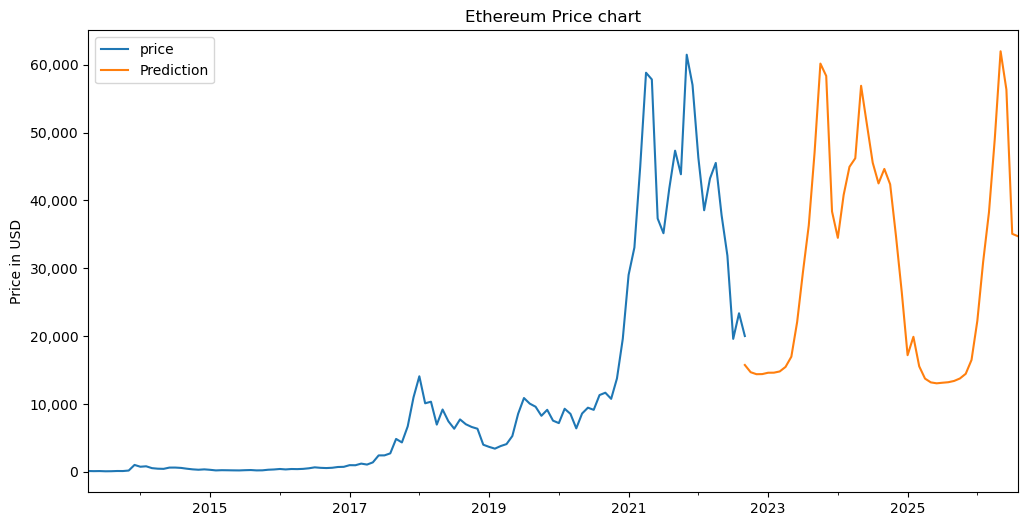

In [94]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df['price'].plot(legend=True,figsize=(12,6),title=title)
predictions['Prediction'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [84]:
# same plot as above but with plotly
result = df.join(predictions['Prediction'], how='outer')
result[['price','Prediction']].iplot()

In [85]:
# in order not to retrain every time we can save the model
model.save('BTC_rnn_model.h5')

In [86]:
# and in order to reload 
# from keras.models import load_model
# model = load_model('BTC_rnn_model.h5')
# model.summary()